## Imports

In [1]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e3_enhance
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data

In [3]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

In [5]:
print('Benign: ', df['diagnosis'].value_counts()[0])
print('Malign: ', df['diagnosis'].value_counts()[1])

Benign:  305
Malign:  195


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   diagnosis                500 non-null    float64
 2   radius_mean              500 non-null    float64
 3   texture_mean             500 non-null    float64
 4   perimeter_mean           500 non-null    float64
 5   area_mean                500 non-null    float64
 6   smoothness_mean          500 non-null    float64
 7   compactness_mean         500 non-null    float64
 8   concavity_mean           500 non-null    float64
 9   concave points_mean      500 non-null    float64
 10  symmetry_mean            500 non-null    float64
 11  fractal_dimension_mean   500 non-null    float64
 12  radius_se                500 non-null    float64
 13  texture_se               500 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,3.263049e+07,0.390000,14.224206,19.086320,92.606620,662.844800,0.095978,0.103948,0.089941,0.049446,...,25.508500,108.258320,896.003200,0.131972,0.256324,0.276420,0.115980,0.292212,0.083778,NaN
std,1.326933e+08,0.488238,3.476809,4.164842,23.983476,349.357241,0.013666,0.053096,0.080259,0.038875,...,6.063133,33.312706,571.074422,0.022739,0.159147,0.209012,0.065896,0.063366,0.018108,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.667040e+05,0.000000,11.807500,16.070000,75.995000,430.550000,0.085992,0.063622,0.028885,0.020245,...,21.017500,84.567500,522.600000,0.116200,0.145925,0.114475,0.063302,0.251700,0.071270,NaN
50%,9.014320e+05,0.000000,13.435000,18.680000,86.735000,556.150000,0.095825,0.091280,0.064315,0.033870,...,25.240000,97.980000,691.750000,0.131250,0.214850,0.231400,0.100650,0.283100,0.079900,NaN
75%,8.910808e+06,1.000000,16.115000,21.562500,106.225000,800.775000,0.105100,0.130500,0.132150,0.074928,...,29.350000,127.150000,1150.750000,0.146000,0.343525,0.389450,0.166850,0.320050,0.092065,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


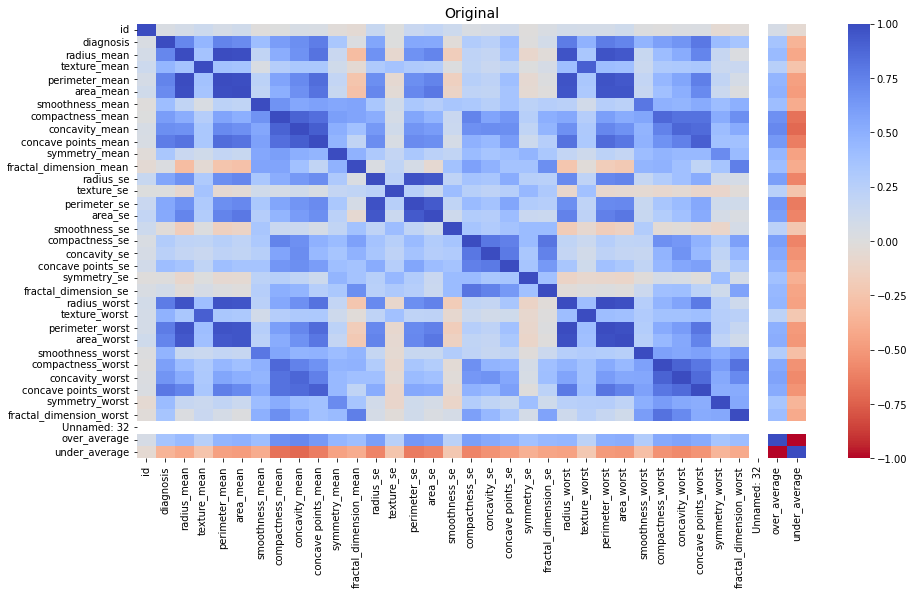

In [10]:
plot_correlation_matrix(df, "Original")

In [11]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0][:195]
non_fraud_df = df.loc[df['diagnosis'] == 1]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
418,906024,0.0,12.70,12.17,80.88,495.0,0.08785,0.05794,0.02360,0.02402,...,566.9,0.1314,0.16070,0.09385,0.08224,0.2775,0.09464,NaN,0,30
130,866714,0.0,12.19,13.29,79.08,455.8,0.10660,0.09509,0.02855,0.02882,...,545.2,0.1427,0.25850,0.09915,0.08187,0.3469,0.09241,NaN,0,30
275,8911164,0.0,11.89,17.36,76.20,435.6,0.12250,0.07210,0.05929,0.07404,...,472.4,0.1359,0.08368,0.07153,0.08946,0.2220,0.06033,NaN,2,28
260,887549,1.0,20.31,27.06,132.90,1288.0,0.10000,0.10880,0.15190,0.09333,...,1844.0,0.1522,0.29450,0.37880,0.16970,0.3151,0.07999,NaN,1,29
177,87281702,1.0,16.46,20.11,109.30,832.9,0.09831,0.15560,0.17930,0.08866,...,981.2,0.1415,0.46670,0.58620,0.20350,0.3054,0.09519,NaN,0,30


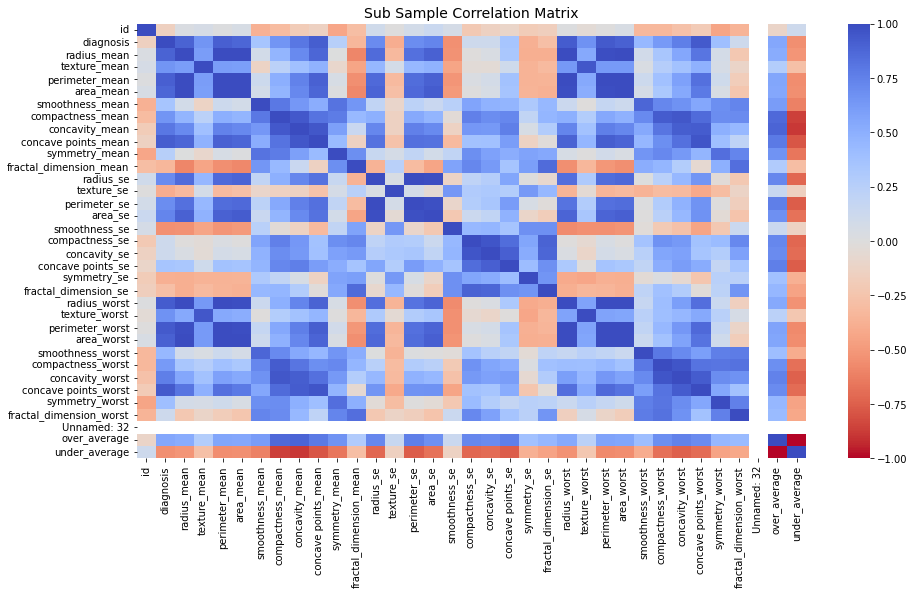

In [12]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

In [13]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [14]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 8))

(['concave points_worst', 'under_average', 'perimeter_worst', 'smoothness_se', 'radius_worst', 'fractal_dimension_mean', 'concave points_mean', 'symmetry_se'], [0.7886685457755465, -0.34015680656202674, 0.7610657780321979, -0.03253133088350129, 0.7552684490586677, -0.01286480784074364, 0.7535595819314368, -0.0008638215559959159])


In [15]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

In [16]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,fractal_dimension_mean,concave points_mean,symmetry_se
303,0.224330,1.0,0.281688,0.285095,0.306881,0.677340,0.088469,0.226852
491,0.286632,1.0,0.505971,0.140347,0.549945,0.538075,0.207654,0.164915
397,0.285086,1.0,0.361146,0.174141,0.381243,0.590107,0.202932,0.236732
359,0.173608,1.0,0.301712,0.219595,0.333518,0.714183,0.069881,0.245978
480,0.195533,1.0,0.353623,0.157758,0.370144,0.644910,0.075895,0.184167


In [17]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,fractal_dimension_mean,concave points_mean,symmetry_se
330,0.680756,1.000000,0.494825,0.187568,0.520533,0.613300,0.349950,0.185814
430,0.850515,0.866667,0.499204,0.223739,0.453663,0.707923,0.482654,0.189867
132,0.450859,1.000000,0.516322,0.156666,0.540233,0.604577,0.278976,0.194427
44,0.552234,1.000000,0.419984,0.107613,0.450333,0.633929,0.261034,0.140975
257,0.765979,0.900000,0.476911,0.326052,0.491953,0.779557,0.617296,0.238632


In [18]:
input_data=malign.to_numpy()
input_data

array([[0.2243299 , 1.        , 0.2816879 , ..., 0.6773399 , 0.08846918,
        0.22685244],
       [0.2866323 , 1.        , 0.50597134, ..., 0.53807471, 0.20765408,
        0.1649145 ],
       [0.28508591, 1.        , 0.3611465 , ..., 0.59010673, 0.20293241,
        0.23673211],
       ...,
       [0.24453608, 0.93333333, 0.33865446, ..., 0.62643678, 0.09666998,
        0.22102597],
       [0.34398625, 1.        , 0.41600318, ..., 0.54577176, 0.13161034,
        0.13540215],
       [0.31408935, 1.        , 0.33578822, ..., 0.58651478, 0.11332008,
        0.2269791 ]])

## Training node

In [19]:
shots = 2500
nr_trash=2
nr_latent=1
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

nr_layers = 4

Qubits: [0, 1, 2, 3, 4, 5]


In [20]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    setAB_amplitude(spec, init_params)
    setAux(spec, reinit_state)

    #encoder 
    for params in encoder_params:
        e3_enhance(params, float(x), spec)

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [21]:
epochs = 500
learning_rate = 0.0003
batch_size = 5
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [22]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [23]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [24]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [25]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [26]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_26648/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [27]:
batches=iterate_batches(training_data, batch_size)

In [28]:
X_training = training_data
X_tes = test_data

In [29]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = nr_layers * 2 * nr_encod_qubits + 2 * len(spec.trash_qubits)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

###  training

In [30]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

In [31]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

benign_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        b_fidel = fidelity(encoder_params, benign_data )
        benign_fid.append(b_fidel)
        print("malign fid:{}".format(b_fidel))
        
        """
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Cancer_encoder_e3-SelectedFeautures-Benign/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()
        """

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.4608049090429427 | Fidelity:0.6852151219970235
Test-Epoch:0 | Loss:1.462153654974072 | Fidelity:0.6843407022295599
malign fid:0.6911227355136095
Epoch:5 | Loss:1.3257366820630867 | Fidelity:0.7550680838345212
Test-Epoch:5 | Loss:1.3244474067211482 | Fidelity:0.7554777299007035
malign fid:0.7580213502063227
Epoch:10 | Loss:1.2228785203428898 | Fidelity:0.8186021155959083
Test-Epoch:10 | Loss:1.2200765332882502 | Fidelity:0.8200925738414729
malign fid:0.8176900569529989
Epoch:15 | Loss:1.1467993202432645 | Fidelity:0.8728331283452656
Test-Epoch:15 | Loss:1.1434379176248533 | Fidelity:0.8749950344250569
malign fid:0.8665950106321081
Epoch:20 | Loss:1.0969018391732652 | Fidelity:0.9123668036973722
Test-Epoch:20 | Loss:1.0935708689061208 | Fidelity:0.9147800583649377
malign fid:0.9001181470983046
Epoch:25 | Loss:1.0667615560313812 | Fidelity:0.9379632009582081
Test-Epoch:25 | Loss:1.0636938814361019 | Fidelity:0.9403629216107942
malign fid:0.9202508399164161
Epoch:30 | Loss

malign fid:0.9524340295629034
Epoch:250 | Loss:1.0197590141701078 | Fidelity:0.9807541075598383
Test-Epoch:250 | Loss:1.018108449538645 | Fidelity:0.9822636215682835
malign fid:0.9531938116672415
Epoch:255 | Loss:1.0196956958463743 | Fidelity:0.9808139388509556
Test-Epoch:255 | Loss:1.0180562420388053 | Fidelity:0.9823135158928856
malign fid:0.9535098328002658
Epoch:260 | Loss:1.0196338122784538 | Fidelity:0.9808711851448609
Test-Epoch:260 | Loss:1.0180266295675733 | Fidelity:0.982341582929857
malign fid:0.9539309052098239
Epoch:265 | Loss:1.0195696162254877 | Fidelity:0.9809302664142322
Test-Epoch:265 | Loss:1.0180019494493153 | Fidelity:0.9823651387771914
malign fid:0.9542804465502369
Epoch:270 | Loss:1.0195070593256006 | Fidelity:0.9809881380568564
Test-Epoch:270 | Loss:1.0179490469474037 | Fidelity:0.9824157831090903
malign fid:0.9545883808280069
Epoch:275 | Loss:1.0194532932987124 | Fidelity:0.9810399809098499
Test-Epoch:275 | Loss:1.0178693119609228 | Fidelity:0.9824922774117739


Test-Epoch:495 | Loss:1.0169809909507934 | Fidelity:0.9833422542206504
malign fid:0.9580972788255795


## Rezults

In [32]:
import matplotlib.pyplot as plt

fidelity: 0.9824008175141427


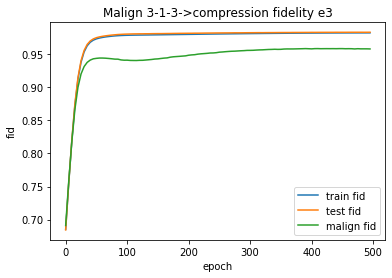

In [42]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(benign_fid),label="malign fid")

plt.legend()
plt.title("Malign 3-1-3->compression fidelity e3",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0179854716884915


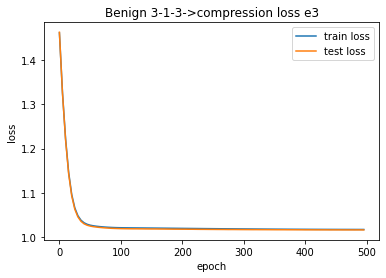

In [43]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Benign 3-1-3->compression loss e3",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [44]:
name = "Cancer_encoder_e3"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples" : num_samples,
                    "batch_size" :batch_size,
                    "epochs" :epochs,
                    "learning_rate" : learning_rate ,
                    "beta1" : beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}
"""
# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )
"""

'\n# open file for writing\nf = open(name+".txt","w")\nf.write( str(experiment_data) )\n'

## Benign performance 

In [36]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

loss = cost(encoder_params, benign_data )
fidel = fidelity(encoder_params, benign_data )

print("Benign results:")
print("fidelity=",fidel)
print("loss=",loss)


C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Benign results:
fidelity= 0.9582494656174738
loss= 1.0440620751101348


## Classifyer

In [37]:
beningn_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    beningn_flist.append(f.item())
    
print(min(beningn_flist))
print(max(beningn_flist))

0.8707970132303233
0.9878314472762385


In [38]:
malign_flist=[]
for b in training_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.9390204253832917
0.9949162875809263


In [39]:
beningn_flist

[0.9777032868944284,
 0.97184252158366,
 0.9677244310972478,
 0.9756752582915195,
 0.959394479296314,
 0.9753110351166403,
 0.9645140921700914,
 0.9541513091136088,
 0.9432710745621553,
 0.9538024348637789,
 0.9634678723009853,
 0.9254400322053548,
 0.9571409803376039,
 0.970813213965888,
 0.9621023796039938,
 0.9786353230696538,
 0.922224986375983,
 0.9692563515067881,
 0.9700051886465211,
 0.9448694910464206,
 0.957262994633475,
 0.9648703005485915,
 0.9726900837914435,
 0.9542227141869773,
 0.9524106172096788,
 0.9489402189785836,
 0.9359280468624438,
 0.9162763747864209,
 0.9740516582463353,
 0.9600340226462974,
 0.965199161771074,
 0.9605558493318,
 0.9521750208595754,
 0.9751046138975705,
 0.9699059228138782,
 0.9471258296482312,
 0.9690947136524394,
 0.9629637334282274,
 0.9516228726969803,
 0.8802507159715025,
 0.9726040129586322,
 0.9384742801683568,
 0.9127638275637135,
 0.949072056222012,
 0.8707970132303233,
 0.9593190816955417,
 0.969931225647497,
 0.9490768075493945,
 0.9

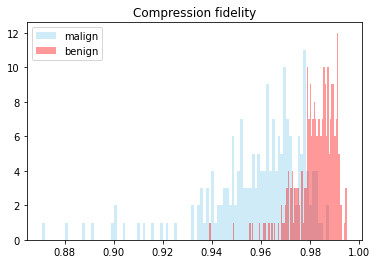

In [40]:
plt.hist(beningn_flist, bins = 100 ,label="malign", color = "skyblue",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()